In [1]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [2]:
import os
import PIL
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os
import shutil
import random
import cv2

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import skvideo
import skvideo.io

def load_video(fn):
    videodata = skvideo.io.vread(fn)
    return videodata

In [4]:
def get_mask_resized_num(targ,mask):
    im2 = Image.fromarray((mask*255).astype(np.uint8)).resize(size=(targ[1],targ[0]), resample=PIL.Image.NEAREST)
    return np.array(im2)

In [5]:
def inflate_mask(mask,radius=5):
    mask_temp = Image.fromarray(mask).filter(ImageFilter.GaussianBlur(radius))
    mask_temp = np.array(mask_temp)
    mask_temp[mask_temp>0]=255
    return mask_temp

In [6]:
def plot_triple(mask1,mask2):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1);plt.imshow(mask1,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,2);plt.imshow(mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,3);plt.imshow(mask1+mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.tight_layout()

In [7]:
def random_jiggle_mask(all_mask,inteligent_random=True):
    min_y, min_x = np.argwhere(all_mask).min(axis=0)
    max_y, max_x = np.argwhere(all_mask).max(axis=0)
    dist_x = max_x-min_x
    dist_y = max_y-min_y
    avail_x = np.arange(0,all_mask.shape[1]-dist_x)
    avail_y = np.arange(0,all_mask.shape[0]-dist_y)
    
    #inteligent_random = True
    if inteligent_random==True:
        prob_x = np.ones(len(avail_x))
        prob_x[((avail_x>=min_x-dist_x)*(avail_x<=max_x))]=.001

        prob_y = np.ones(len(avail_y))
        prob_y[((avail_y>=min_y)*(avail_y<=max_y))]=.001

        choose_x = random.choices(avail_x,weights=prob_x,k=1)[0]
        choose_y = random.choices(avail_y,weights=prob_y,k=1)[0]
    else:        
        choose_x = random.choice(avail_x)
        choose_y = random.choice(avail_y)
    
    e_mask = np.zeros(all_mask.shape)
    blob = all_mask[min_y:max_y,min_x:max_x]
    e_mask[choose_y:choose_y+dist_y,choose_x:choose_x+dist_x] = blob
    return e_mask.astype(np.uint8)

In [8]:
indir = '~/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4'
indir = os.path.expanduser(indir)
indir

'/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4'

In [9]:
folders = [folder for folder in os.listdir(indir) if not folder.startswith('.')]
folders.sort()
n = len(folders)
print(n)
folders[0:3]

499


['ALS_IceBucket_Challenge', 'CPR', 'abseiling']

In [10]:
fn_temp = '{indir}/{folder}/{folder}_{video}_item_0_masks.npy'

(20, 499)
(0.8550100200400802, 8533)


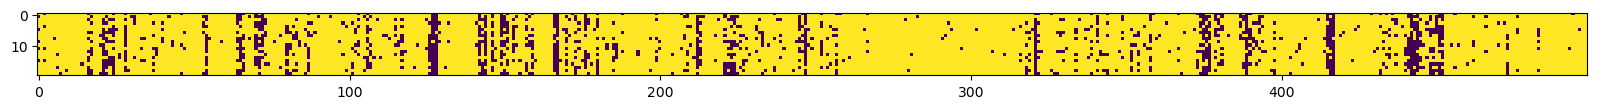

In [11]:
#good_videos = np.load('good_videos.npy')
good_videos = np.load('good_videos_1p.npy')
print(good_videos.shape)
print((good_videos.mean(),good_videos.sum()))
plt.figure(figsize=np.array((10,5))*2)
plt.imshow(good_videos)

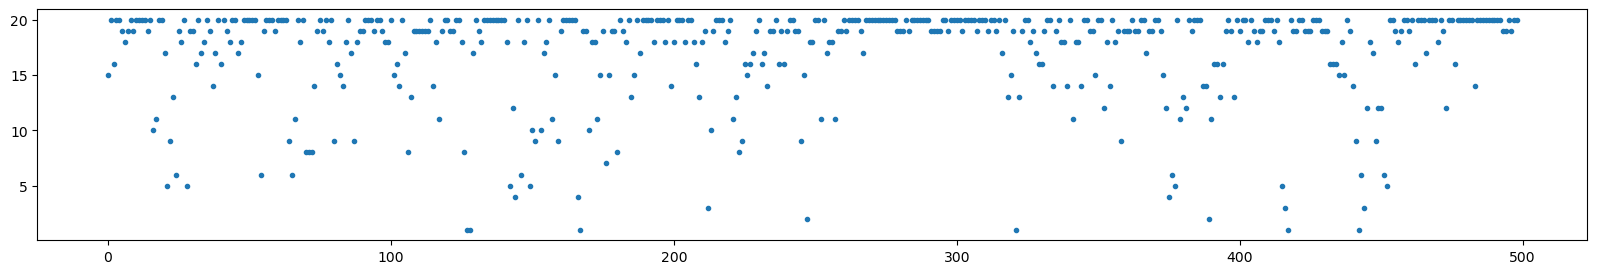

In [12]:
plt.figure(figsize=np.array((20,3)))
plt.plot(good_videos.sum(axis=0),'.')

In [13]:
good_videos[:,good_videos.sum(axis=0)<20] = False

In [14]:
# good_videos[:,good_videos.sum(axis=0)<15] = False
# good_videos[15:20,:] = False

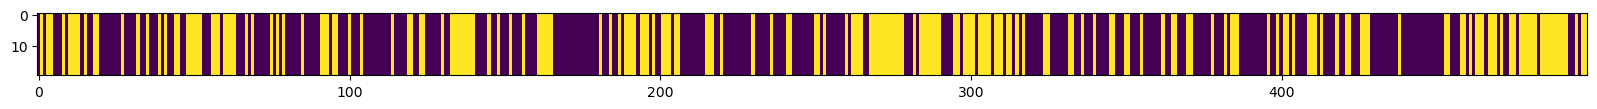

In [15]:
plt.figure(figsize=np.array((10,5))*2)
plt.imshow(good_videos)

In [16]:
print(good_videos.mean(),good_videos.sum())

0.40681362725450904 4060


In [17]:
###

calc_or_load = 'load'

if calc_or_load=='calc':

    fn_temp = '{indir}/{folder}/{folder}_{video}_item_0_masks.npy'
    pad_fn_temp = './Data/haa500_v1_1_resized/video/{folder}/{folder}_{video}_padding.npy'

    fns = []
    masks = []
    paddings = []

    for f in tqdm(range(good_videos.shape[1])):
        for v in range(good_videos.shape[0]):
            if bool(good_videos[v,f])==True:
                fn = fn_temp.format(indir=indir,folder=folders[f],video=f'{v:03d}')

                mask = np.load(fn)
                mask = inflate_mask((( mask.sum(axis=0) >0 )*255).astype(np.uint8),radius=15)
                mask = get_mask_resized_num((360, 640),mask)


                pad_fn = pad_fn_temp.format(folder=folders[f],video=f'{v:03d}')
                pad = np.load(pad_fn)

                fns.append(fn)
                masks.append(mask)
                paddings.append(pad)
                
                
    
    
    
    masks = np.array(masks)
    fns = np.array(fns)
    paddings = (np.array(paddings)==0)*1
    #paddings = np.array(paddings)
    
    np.savez_compressed('./Data/data_good_videos_1p_masks.npz',arr=masks)
    np.savez_compressed('./Data/data_good_videos_1p_fns.npz',arr=fns)
    np.savez_compressed('./Data/data_good_videos_1p_paddings.npz',arr=paddings)
    #np.savez_compressed('./Data/data_good_videos_1p.npz',masks=masks,fns=fns,paddings=paddings)
    
elif calc_or_load=='load':
    
    masks = np.load('./Data/data_good_videos_1p_masks.npz')['arr']
    fns = np.load('./Data/data_good_videos_1p_fns.npz')['arr']
    paddings = np.load('./Data/data_good_videos_1p_paddings.npz')['arr']
    
    #a = np.load('./Data/data_good_videos_1p.npz')
    ## TODO fix loading
    #masks = a['masks']
    #fns = a['fns']
    #paddings = a['paddings']
    #paddings = (paddings==0)*1

    #del a
    
    print(masks.shape)
    print(fns.shape)
    print(paddings.shape)

(4060, 360, 640)
(4060,)
(4060, 360, 640)


In [18]:
masks.shape

(4060, 360, 640)

In [19]:
paddings.shape

(4060, 360, 640)

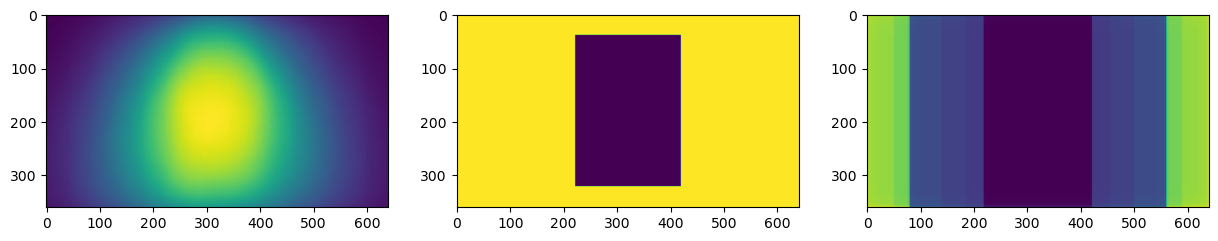

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1);plt.imshow(masks.mean(axis=0))
plt.subplot(1,3,2);plt.imshow(paddings.max(axis=0))
plt.subplot(1,3,3);plt.imshow(paddings.mean(axis=0))
#plt.show()

In [21]:
perc = [((masks[i,:,:]+paddings[i,:,:])==0).sum() / (360*640) for i in range(masks.shape[0])]

In [25]:
np.array(perc).mean()

0.5839219434181717

In [47]:
# %%time
# filled_spots = np.load('./Data/data_inpainting_idx_filled_spots.npz')['arr']
# spots_found_for = np.load('./Data/data_inpainting_idx_spots_found_for.npz')['arr']
# where_to_inpaint_idx = np.load('./Data/data_inpainting_idx_where_to_inpaint_idx.npz')['arr']
# masks_to_inpain = np.load('./Data/data_inpainting_idx_masks_to_inpain.npz')['arr']

In [ ]:
calc_or_load_inpaint_idx = 'continue'

if calc_or_load_inpaint_idx == 'calc':
    
    n = masks.shape[0]
    filled_spots = np.repeat(False,n)
    spots_found_for = np.repeat(False,n)
    where_to_inpaint_idx = np.zeros(n)
    masks_to_inpaint = np.zeros(masks.shape) # To keep the jiggled masks 

    plt.ioff()
    for i in tqdm(range(n)):
        this_mask = masks[i,:,:] # grab a mask
        
        for rr in range(50): #V2.0 jiggle a hundo times
            this_mask = random_jiggle_mask(this_mask,inteligent_random=False) # V2.0 Jiggle the mask 

            ## N.B if comp is <1.0 or <255
            where_fits = np.array( [(  this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float)   ).max()   <=1.0 for j in range(n)] ) # Teh l33t alg0
            where_fits[filled_spots] = False # Make sure not already filles

            if where_fits.sum()>0:
                #print('triggered')
                where_fits_idx = np.nonzero(where_fits)[0]
                temp = np.argsort([    ((this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float))==0).sum()       for j in where_fits_idx])[0]
                where_fits_choose = where_fits_idx[temp]

                # Bookkeeping
                filled_spots[where_fits_choose] = True
                spots_found_for[i]=True
                where_to_inpaint_idx[i] = where_fits_choose
                masks_to_inpaint[i,:,:] = this_mask # V2.0

                plot_triple(this_mask,masks[where_fits_choose,:,:]+paddings[where_fits_choose,:,:])
                plt.savefig(f'./Data/inpaint-triplet-figs/{i:04d}.png')
                plt.close()
                
                break # If found a spot, break out of the for loop
                
            if np.mod(i,100)==0:
                np.savez_compressed('./Data/data_inpainting_idx_filled_spots.npz',arr=filled_spots)
                np.savez_compressed('./Data/data_inpainting_idx_spots_found_for.npz',arr=spots_found_for)
                np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx.npz',arr=where_to_inpaint_idx)
                np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain.npz',arr=masks_to_inpaint)

    print('saving')
    #np.savez_compressed('./Data/data_inpainting_idx.npz',filled_spots=filled_spots,spots_found_for=spots_found_for,where_to_inpaint_idx=where_to_inpaint_idx,masks_to_inpain=masks_to_inpaint)
    np.savez_compressed('./Data/data_inpainting_idx_filled_spots.npz',arr=filled_spots)
    np.savez_compressed('./Data/data_inpainting_idx_spots_found_for.npz',arr=spots_found_for)
    np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx.npz',arr=where_to_inpaint_idx)
    np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain.npz',arr=masks_to_inpaint)
    print('done')
    
elif calc_or_load_inpaint_idx == 'load':

    filled_spots = np.load('./Data/data_inpainting_idx_filled_spots.npz')['arr']
    spots_found_for = np.load('./Data/data_inpainting_idx_spots_found_for.npz')['arr']
    where_to_inpaint_idx = np.load('./Data/data_inpainting_idx_where_to_inpaint_idx.npz')['arr']
    masks_to_inpain = np.load('./Data/data_inpainting_idx_masks_to_inpain.npz')['arr']

    
elif calc_or_load_inpaint_idx == 'continue':
    
    n = masks.shape[0]
    filled_spots = np.load('./Data/data_inpainting_idx_filled_spots.npz')['arr']
    spots_found_for = np.load('./Data/data_inpainting_idx_spots_found_for.npz')['arr']
    where_to_inpaint_idx = np.load('./Data/data_inpainting_idx_where_to_inpaint_idx.npz')['arr']
    masks_to_inpaint = np.load('./Data/data_inpainting_idx_masks_to_inpain.npz')['arr']
    start_point = spots_found_for.nonzero()[0].max()
    
    plt.ioff()
    for i in tqdm(range(start_point,n)):
        this_mask = masks[i,:,:] # grab a mask
        
        for rr in range(50): #V2.0 jiggle a hundo times
            this_mask = random_jiggle_mask(this_mask,inteligent_random=False) # V2.0 Jiggle the mask 

            ## N.B if comp is <1.0 or <255
            where_fits = np.array( [(  this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float)   ).max()   <=1.0 for j in range(n)] ) # Teh l33t alg0
            where_fits[filled_spots] = False # Make sure not already filles

            if where_fits.sum()>0:
                #print('triggered')
                where_fits_idx = np.nonzero(where_fits)[0]
                temp = np.argsort([    ((this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float))==0).sum()       for j in where_fits_idx])[0]
                where_fits_choose = where_fits_idx[temp]

                # Bookkeeping
                filled_spots[where_fits_choose] = True
                spots_found_for[i]=True
                where_to_inpaint_idx[i] = where_fits_choose
                masks_to_inpaint[i,:,:] = this_mask # V2.0

                plot_triple(this_mask,masks[where_fits_choose,:,:]+paddings[where_fits_choose,:,:])
                plt.savefig(f'./Data/inpaint-triplet-figs/{i:04d}.png')
                plt.close()
                
                break # If found a spot, break out of the for loop
                
        if np.mod(i,500)==0:
            np.savez_compressed('./Data/data_inpainting_idx_filled_spots.npz',arr=filled_spots)
            np.savez_compressed('./Data/data_inpainting_idx_spots_found_for.npz',arr=spots_found_for)
            np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx.npz',arr=where_to_inpaint_idx)
            np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain.npz',arr=masks_to_inpaint)

    print('saving')
    #np.savez_compressed('./Data/data_inpainting_idx.npz',filled_spots=filled_spots,spots_found_for=spots_found_for,where_to_inpaint_idx=where_to_inpaint_idx,masks_to_inpain=masks_to_inpaint)
    np.savez_compressed('./Data/data_inpainting_idx_filled_spots.npz',arr=filled_spots)
    np.savez_compressed('./Data/data_inpainting_idx_spots_found_for.npz',arr=spots_found_for)
    np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx.npz',arr=where_to_inpaint_idx)
    np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain.npz',arr=masks_to_inpaint)
    print('done')

In [31]:
import numpy as np
import os
from matplotlib import pyplot as plt

a = [int(f.replace('.png','')) for f in os.listdir('./Data/inpaint-triplet-figs') if f.endswith('.png')]
a.sort()
a = np.array(a)
print(f'{a.shape[0]/a.max()*100:.2f}%')

73.86%
